In [1]:
import climtas
import climtas.nci
import dask as da
from dask.distributed import LocalCluster, Client
import xarray as xr

## Creating monthly climatology file from daily climatology

In [2]:
mhw = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/MHW-sev/mhw_severity.pc90.*.nc').sel(lat=slice(-53, -28), lon=slice(135, 190))
clim = mhw.climatology

In [3]:
clim

<xarray.DataArray 'climatology' (time366: 366, lat: 100, lon: 220)>
dask.array<getitem, shape=(366, 100, 220), dtype=float32, chunksize=(366, 80, 120), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -52.88 -52.62 -52.38 -52.12 ... -28.62 -28.38 -28.12
  * lon      (lon) float64 135.1 135.4 135.6 135.9 ... 189.1 189.4 189.6 189.9
  * time366  (time366) datetime64[ns] 1983-12-30 1983-12-31 ... 1984-12-29
Attributes:
    units:      degrees C
    long_name:  Climatological sea surface temperature

In [4]:
climatology = clim.groupby("time366.month").mean("time366")

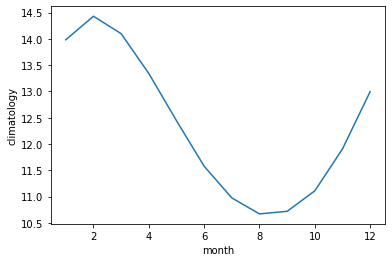

In [6]:
climatology.mean(dim=('lat', 'lon')).plot()

In [7]:
climatology

<xarray.DataArray 'climatology' (month: 12, lat: 100, lon: 220)>
dask.array<stack, shape=(12, 100, 220), dtype=float32, chunksize=(1, 80, 120), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -52.88 -52.62 -52.38 -52.12 ... -28.62 -28.38 -28.12
  * lon      (lon) float64 135.1 135.4 135.6 135.9 ... 189.1 189.4 189.6 189.9
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [9]:
climtas.io.to_netcdf_throttled(climatology.to_dataset(name='sst-clim'), '/g/data/e14/cp3790/Charuni/MHW-sev/sst-clim.nc')

## Creating a new climatology file based on repeating the monthly climatology for 41 years

In [2]:
mean_climatology = xr.open_dataset('/g/data/e14/cp3790/Charuni/MHW-sev/sst-clim.nc')

In [39]:
def copy_clim(target_da,input_da):
    t_time=target_da["time"].dt.month[0]
    target_da[:] = input_da.sel(month=t_time)
    return(target_da)

In [43]:
ds = xr.open_dataset('/g/data/ub4/era5/netcdf/surface/msl/monthly/msl_era5_mon_global_197901_201912.nc').sel(latitude=slice(-28, -53), longitude=slice(135, 190))
ds

<xarray.Dataset>
Dimensions:    (latitude: 101, longitude: 180, time: 492)
Coordinates:
  * longitude  (longitude) float32 135.0 135.25 135.5 ... 179.25 179.5 179.75
  * latitude   (latitude) float32 -28.0 -28.25 -28.5 ... -52.5 -52.75 -53.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2019-12-01
Data variables:
    msl        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-05-14 05:09:40 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [40]:
new_climatology = xr.DataArray(np.empty(ds.msl.shape),
                               coords=ds.msl.coords,
                               dims=ds.msl.dims,
                               name="climatology")

In [42]:
new_climatology = new_climatology.groupby(new_climatology.time.dt.month).apply(copy_clim,input_da=mean_climatology)

TypeError: float() argument must be a string or a number, not 'method'